<a href="https://colab.research.google.com/github/amfei/Statistical_Inference/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## The company recently tested a new search ranking algorithm.
The goal of the new algorithm is to increase the number of users who actually make a booking after searching for hotels or flights (this is called the conversion rate).

The Product Team is thinking about launching this new ranking system for everyone, but only if the experiment shows two things:

The conversion rate must go up and the improvement must be statistically significant (not just random).

The time it takes users to book must not get longer — ideally, it should either stay the same or even get faster.

###The Data Provided
They shared two datasets for me to analyze:

1. sessions_data.csv
This file contains session-level data, meaning each time a user searched or interacted with the website:


Column	Description
session_id	Unique ID for each browsing session
user_id	ID for the user (missing if not logged in)
session_start_timestamp	When the session started
booking_timestamp	When the user made a booking (if any)
time_to_booking	How many minutes it took to make the booking (if any)
conversion (needs to be created)	1 if the session ended with a booking, 0 if not
2. users_data.csv
This file contains user-level information:


Column	Description
user_id	Unique ID for each logged-in user
experiment_group	Which group the user belonged to (control or variant)
 The experiment was designed so that users were split 50/50 between the control group (old system) and the variant group (new ranking algorithm).

## The Goals of  Analysis
I needed to answer two main questions:

Primary Metric (Conversion Rate):

Does the new ranking system significantly increase the number of bookings compared to the old system?

Guardrail Metric (Time to Book):

Does the new system keep the booking time the same or reduce it?
(We don't want users taking longer to book!)

### How I Approached the Problem
First, I processed the data and created the conversion column (1 = booking made, 0 = no booking).

Then I used statistical tests to compare the control and variant groups:

### Z-test for proportions to compare the conversion rates.

Normality tests to check if booking times were normally distributed.

Based on normality, I chose between t-tests or Mann-Whitney U-tests to compare booking times.

###Finally, I interpreted the p-values from the tests:

If the conversion rate improved significantly and booking time did not get worse,
then the new algorithm would be recommended for full rollout.



## 1. Understand A/B Testing Basics

You split users into two groups:

Control group: uses the old (current) system.

Variant group: uses the new (experimental) system.

Goal: Compare the performance between the two groups.

 Why?

To see if the new search ranking algorithm really improves conversion rates.

We want to isolate the effect of the algorithm, removing other influences.

We must know how experiments work and how to fairly compare groups.

## 2. Understand Conversion Rate (Primary Metric)
conversion rate is the percentage of users who complete a desired action (e.g., booking a trip).


Conversion Rate = Number of Conversions / Total Number of Users


In this project: A "conversion" means a successful booking.

If a user made a booking → conversion = 1, otherwise conversion = 0.

 This is your main metric to measure success.

## 3. Check for Sample Ratio Mismatch (SRM)


In an A/B test, both groups should have roughly equal numbers of users (unless intentionally different).


If the groups are not split properly (e.g., 70%-30% instead of 50%-50%), the test results will be biased and unreliable.

How is SRM checked?

Using a Chi-Square test to compare the observed vs. expected number of users in each group.

If p-value < alpha, it means the randomization failed.

Always check SRM before analyzing results!

## 4. Statistical Tests We Must Know


Two-Proportion Z-Test:	To compare the conversion rates between control and variant groups.

Chi-Square Test:	To check if the groups are properly randomized (SRM check).

T-Test (or Mann-Whitney U Test):	To compare average time to booking between control and variant users.


## 5. Understand p-values and Confidence Levels

p-value measures the probability that the observed difference happened by random chance.

If the p-value is small (below a threshold like 0.1 or 0.05), you conclude the difference is statistically significant.

What is the confidence level?

The confidence level tells how sure you are that the results are not random.

In this project:

Confidence Level = 90% (meaning α = 0.10).

 If:

𝑝-value <𝛼

then the result is considered statistically significant.

## 6. Understand Effect Size

Effect Size measures how big the difference is between the two groups — not just whether a difference exists.

Why is it important?

A result might be statistically significant but too small to matter practically.

You need to know how much improvement the new algorithm brings.

In this project:

Effect Size
=(Conversion Rate (Variant)/Conversion Rate (Control))−1

WE need both statistical significance and practical importance to decide.

##7. Understand Guardrail Metrics
 Guardrail Metric : a metric used to ensure the new version doesn’t harm important user experience factors.

In this project:

Guardrail Metric = Time to Booking.

Even if the conversion rate improves,
if time to book becomes much longer, the new algorithm could hurt the overall business.

Guardrail rule:

If time to booking becomes significantly worse → don't launch the new algorithm.



In [ ]:
# IMPORT PACKAGES
import pandas as pd
from scipy.stats import chisquare
from pingouin import ttest



# FIXED PARAMETERS
confidence_level = 0.90  # Set desired confidence level (90%)
alpha = 1 - confidence_level  # Significance level for hypothesis tests

# LOAD DATA
users = pd.read_csv('users_data.csv') # Load user and experiment group data
sessions = pd.read_csv('sessions_data.csv') # Load session/booking data




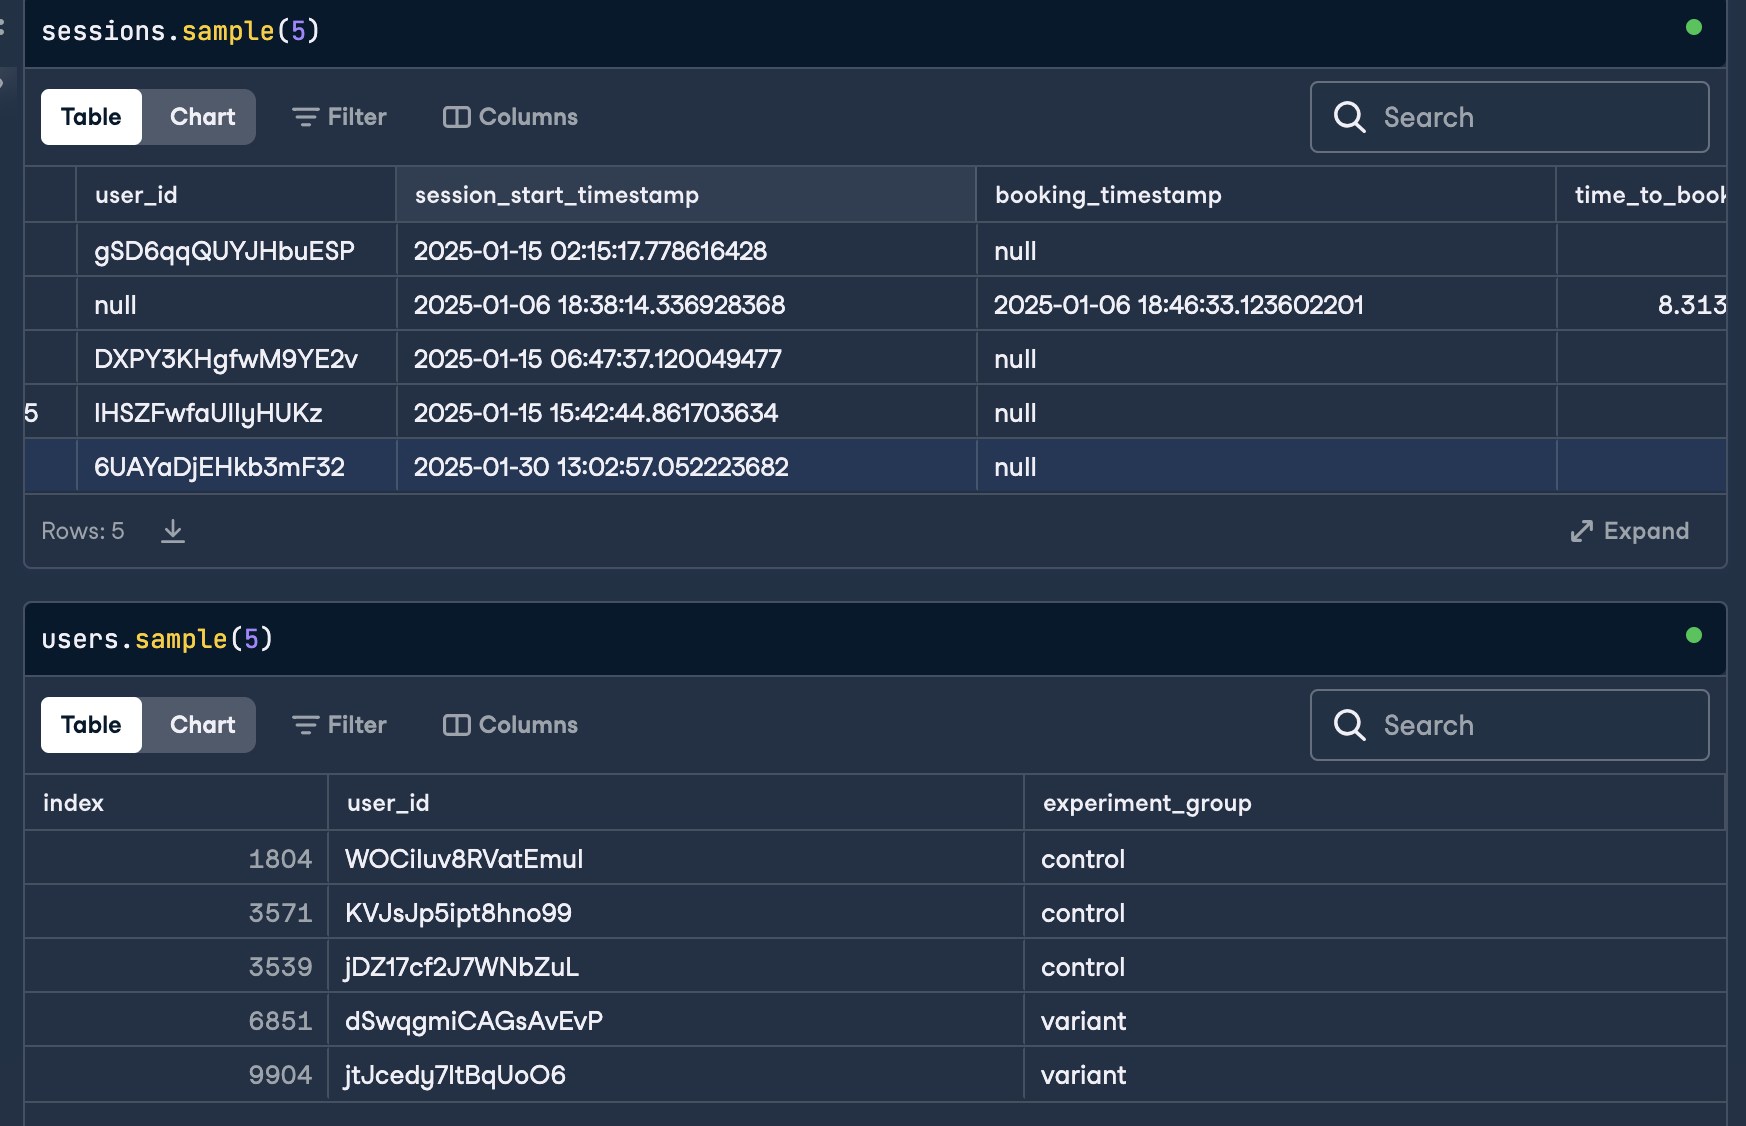

sessions_data.csv

column	data type	description

session_id	(string):	Unique session identifier (unique for each row)

user_id	(string):	Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions)

session_start_timestamp	(string):	When a session started

booking_timestamp	(string):	When a booking was made (missing if no booking was made during a session)

time_to_booking	(float):	time from start of the session to booking, in minutes (missing if no booking was made during a session)

conversion	(integer):	New column to create: did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1)

users_data.csv

column	data type	description

user_id	(string):	Unique user identifier (only logged-in users in this table)

experiment_group	(string):	control / variant split for the experiment (expected to be equal 50/50)


In [ ]:
# JOIN DATA
# Merge on user ID to enrich sessions with user experiment group
sessions_x_users = sessions.merge(users, on = 'user_id', how = 'inner')

# COMPUTE PRIMARY METRIC
# Binary conversion flag: 1 if booking occurred, 0 otherwise
sessions_x_users['conversion'] = sessions_x_users['booking_timestamp'].notnull().astype(int)

# SAMPLE RATIO MISMATCH TEST
# Check if the number of users in each experiment group is balanced (a basic A/A sanity check)
groups_count = sessions_x_users['experiment_group'].value_counts()
print(groups_count)

variant 7653

control 7630

In [ ]:
n = sessions_x_users.shape[0] # Total sample size
srm_chi2_stat, srm_chi2_pval = chisquare(f_obs = groups_count, f_exp = (n/2, n/2))
srm_chi2_pval = round(srm_chi2_pval, 4)
print(f'\nSRM\np-value: {srm_chi2_pval}') # If p < alpha, there's likely a sampling issue issue


SRM p-value: 0.8524

It means the actual split between control and variant groups is very close to what we expected.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# DEFINE FUNCTIONS
def estimate_effect_size(df, metric) :
    """
    Calculate relative effect size

    Parameters:
    - df (pd.DataFrame): data with experiment_group ('control', 'variant') and metric columns.
    - metric (str): name of the metric column

    Returns:
    - effect_size (float): average treatment effect (effect size)
    """
    avg_metric_per_group = df.groupby('experiment_group')[metric].mean()
    effect_size = avg_metric_per_group['variant'] / avg_metric_per_group['control'] - 1
    return effect_size

# EFFECT ANALYSIS - PRIMARY METRIC
# Compute success counts and sample sizes for each group
success_counts = sessions_x_users.groupby('experiment_group')['conversion'].sum().loc[['control', 'variant']]
sample_sizes = sessions_x_users['experiment_group'].value_counts().loc[['control', 'variant']]

# Run Z-test for proportions (binary conversion metric)
zstat_primary, pval_primary = proportions_ztest(
    success_counts,
    sample_sizes,
    alternative = 'two-sided',
)
pval_primary = round(pval_primary, 4)

# Estimate effect size for the conversion metric
effect_size_primary = estimate_effect_size(sessions_x_users, 'conversion')
effect_size_primary = round(effect_size_primary, 4)
print(f'\nPrimary metric\np-value: {pval_primary: .4f} | effect size: {effect_size_primary: .4f}')


Primary metric p-value: 0.0002

effect size: 0.1422

In [ ]:
# EFFECT ANALYSIS - GUARDRAIL METRIC
# T-test on time to booking for control vs variant
stats_guardrail = ttest(
    sessions_x_users.loc[(sessions_x_users['experiment_group'] == 'control'), 'time_to_booking'],
    sessions_x_users.loc[(sessions_x_users['experiment_group'] == 'variant'), 'time_to_booking'],
    alternative='two-sided',
)
pval_guardrail, tstat_guardrail = stats_guardrail['p-val'].values[0], stats_guardrail['T'].values[0]
pval_guardrail = round(pval_guardrail, 4)

# Estimate effect size for the guardrail metric
effect_size_guardrail = estimate_effect_size(sessions_x_users, 'time_to_booking')
effect_size_guardrail = round(effect_size_guardrail, 4)
print(f'\nGuardrail\np-value: {pval_guardrail} | effect size: {effect_size_guardrail}')

# DECISION
# Primary metric must be statistically significant and show positive effect (increase)
criteria_full_on_primary = (pval_primary < alpha) & (effect_size_primary > 0)

# Guardrail must either be statistically insignificant or whow positive effect (decrease)
criteria_full_on_guardrail = (pval_guardrail > alpha) | (effect_size_guardrail <= 0)

# Final launch decision based on both metrics
if criteria_full_on_primary and criteria_full_on_guardrail:
    decision_full_on = 'Yes'
    print('\nThe experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!')
else:
    decision_full_on = 'No'
    print('\nThe experiment results are inconclusive or the guardrail metric was harmed, we are pulling back!')



Guardrail

p-value: 0.5365

effect size: -0.0079

The experiment results are significantly positive and the guardrail metric was not harmed, we are going full on!

In [3]:
## A/B Test for Email Subject Lines
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from statsmodels.stats.proportion import proportions_ztest

# Seed for reproducibility
np.random.seed(42)

# ------------------------------
# 1. Simulate user groups
# ------------------------------
n = 14000  # total sample size (7000 per group)
users = pd.DataFrame({
    'user_id': np.arange(1, n + 1),
    'group': ['control'] * (n//2) + ['variant'] * (n//2)
})

# ------------------------------
# 2. Simulate outcomes
# ------------------------------

# Simulate open rates
open_rate_control = 0.20
open_rate_variant = 0.23

# Simulate unsubs (guardrail)
unsub_rate_control = 0.01
unsub_rate_variant = 0.012  # slight increase

users['opened'] = users['group'].apply(
    lambda g: np.random.binomial(1, open_rate_control if g == 'control' else open_rate_variant)
)

users['unsubscribed'] = users['group'].apply(
    lambda g: np.random.binomial(1, unsub_rate_control if g == 'control' else unsub_rate_variant)
)
print(users)
# ------------------------------
# 3. SRM Check (Chi-Square Test)
# ------------------------------
obs = users['group'].value_counts().values
expected = [n/2, n/2]
srm_pval = chisquare(f_obs=obs, f_exp=expected).pvalue

print(f"✅ SRM p-value: {srm_pval:.4f} → {'PASS' if srm_pval > 0.05 else 'FAIL'}")

# ------------------------------
# 4. Z-test for Open Rate (Primary Metric)
# ------------------------------
successes = users.groupby('group')['opened'].sum()
samples = users['group'].value_counts().loc[['control', 'variant']]

zstat, pval_open = proportions_ztest(successes, samples)
effect_size_open = (successes['variant'] / samples['variant']) / (successes['control'] / samples['control']) - 1

print(f"\n📬 Open Rate Comparison:")
print(f"p-value: {pval_open:.4f}")
print(f"Effect size: {effect_size_open:.2%}")

# ------------------------------
# 5. Guardrail: Unsubscribe Rate
# ------------------------------
unsub_success = users.groupby('group')['unsubscribed'].sum()
unsub_samples = samples

zstat_unsub, pval_unsub = proportions_ztest(unsub_success, unsub_samples)
effect_size_unsub = (unsub_success['variant'] / unsub_samples['variant']) / (unsub_success['control'] / unsub_samples['control']) - 1

print(f"\n🚧 Unsubscribe Rate (Guardrail):")
print(f"p-value: {pval_unsub:.4f}")
print(f"Effect size: {effect_size_unsub:.2%}")

# ------------------------------
# 6. Final Decision
# ------------------------------

alpha = 0.05
launch = (pval_open < alpha and effect_size_open > 0) and (pval_unsub > alpha or effect_size_unsub <= 0)

print("\n🚀 FINAL DECISION:")
if launch:
    print("✅ Launch the new subject line (variant is better and safe).")
else:
    print("❌ Do NOT launch — effect is not significant or guardrail was violated.")


       user_id    group  opened  unsubscribed
0            1  control       0             0
1            2  control       1             0
2            3  control       0             0
3            4  control       0             0
4            5  control       0             0
...        ...      ...     ...           ...
13995    13996  variant       0             0
13996    13997  variant       1             0
13997    13998  variant       0             0
13998    13999  variant       0             0
13999    14000  variant       0             0

[14000 rows x 4 columns]
✅ SRM p-value: 1.0000 → PASS

📬 Open Rate Comparison:
p-value: 0.0005
Effect size: 12.02%

🚧 Unsubscribe Rate (Guardrail):
p-value: 0.8143
Effect size: -3.57%

🚀 FINAL DECISION:
✅ Launch the new subject line (variant is better and safe).
